Настройка гиперпараметров модели

In [5]:
epsilon = 0.1 # Параметр эпсилон при использовании эпсилон жадной стратегии
gamma = 0.8 # Коэффциент дисконтирования гамма
random_seed = 9 #Random seed
time_delay = 1 # Задержка времени при отрисовке процесса игры после обучения (секунды)

In [6]:
#@title Вывод карты
lr_rate = 0.9 # Параметр альфа, отвечающиий за скорость обучения

import gym
import numpy as np
import time


def generate_random_map(size, p, sd):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False
    np.random.seed(sd)

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0,0))
        while frontier:
            r, c = frontier.pop()
            if not (r,c) in discovered:
                discovered.add((r,c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == 'G':
                        return True
                    if (res[r_new][c_new] not in '#H'):
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]


random_map = generate_random_map(size=6, p=0.8, sd = random_seed)
maze = random_map
env = gym.make("FrozenLake-v0", desc=random_map, is_slippery=False) #is slippery removes possibility to get in incorrect state after an action
print("Ваша карта")
env.render()



Ваша карта

SFFFFF
FFFFFH
HFFFHF
FFFFHF
HHHFFH
FHHFFG


In [7]:
#@title Вывод количества побед и номера игры, когда впервые было одержано 5 побед подряд
def choose_action(state):
    action=0
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0,env.action_space.n) #***
        #action = env.action_space.sample()
    else:
        action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

def learn(state, state2, reward, action, done):
    #Q-learning
    if done:
      Q[state, action] = Q[state, action] + lr_rate * (reward - Q[state, action])
    else:
      Q[state, action] = Q[state, action] + lr_rate * (reward + gamma * np.max(Q[state2, :]) - Q[state, action])


from tqdm import tqdm
# Inititalization
wins_arr = [] #delete
np.random.seed(random_seed)
total_episodes = 10000
max_steps = 100
Q = np.zeros((env.observation_space.n, env.action_space.n))
min_episode = 0 #delete
#Main cycle
for episode in tqdm(range(total_episodes)):
    state = env.reset()
    t = 0
    while t < max_steps:
      #delete
        if episode > 5 and wins_arr[episode-5] == 1 and wins_arr[episode-4] == 1 and wins_arr[episode-3] == 1 and wins_arr[episode-2] == 1 and wins_arr[episode-1] == 1 and min_episode ==0:
          min_episode = episode
        
        t += 1

        action = choose_action(state)

        state2, reward, done, info = env.step(action)

        if t == max_steps:
          done = True  

        learn(state, state2, reward, action, done)

        state = state2

        if done and reward == 1:
          wins_arr.append(1) #record if won
          break
        if done:
          wins_arr.append(0) #record if lost
          break

#print("Таблица ценностей действий")
#print(np.round(Q,2))
#Number of wins
print('')
print("Количество побед в серии из 10 000 игр: ", np.sum(wins_arr))
#Number of the episode
print("Пять побед подряд впервые было одержано в игре ",min_episode)

100%|██████████| 10000/10000 [00:04<00:00, 2481.26it/s]


Количество побед в серии из 10 000 игр:  8267
Пять побед подряд впервые было одержано в игре  367


In [8]:
#@title Отдельная игра после обучения
#Just 1 game to check if Q-table fits to win
from IPython.display import clear_output
import time

def choose_action_one_game(state):
    action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action
states=[]
t = 0
state = env.reset()

while(t<1000):
  env.render()
  time.sleep(time_delay)
  clear_output(wait=True)
  action = choose_action_one_game(state)  
  state2, reward, done, info = env.step(action)  
  #print(reward)
  states.append(state)
  state = state2
  t += 1
  if done and reward == 1:
    wn=1
  if done:
    break
if wn == 1:
  print("!!!Победа!!!")

!!!Победа!!!


c:\users\xiaomi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


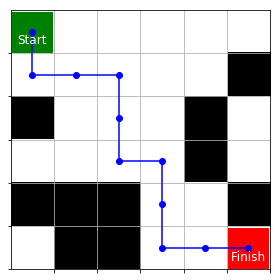

In [9]:
#@title Построение карты маршрута
import matplotlib.pyplot as plt

def make_maze_pic(maze):
  maze_pic=[]
  for i in range(len(maze)):
    row = []
    for j in range(len(maze[i])):
      if maze[i][j] == 'S':
        row.append(0)
      if maze[i][j] == 'F':
        row.append(0)
      if maze[i][j] == 'H':
        row.append(1)
      if maze[i][j] == 'G':
        row.append(0)
    maze_pic.append(row)
  maze_pic = np.array(maze_pic)
  return maze_pic
  

#Make maze fit to plot
maze_pic = make_maze_pic(maze)
nrows, ncols = maze_pic.shape

#Arrays of picture elements
rw = np.remainder(states,nrows)
cl = np.floor_divide(states,nrows)
rw = np.append(rw, [nrows-1])
cl = np.append(cl,[ncols-1])

#Picture plotting
fig, ax1 = plt.subplots(1, 1, tight_layout=True)
ax1.clear()
ax1.set_xticks(np.arange(0.5, nrows, step=1))
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0.5, ncols, step=1))
ax1.set_yticklabels([])
ax1.grid(True)
ax1.plot([0],[0], "gs", markersize=40)  # start is a big green square
ax1.text(0, 0.2,"Start", ha="center", va="center", color="white", fontsize=12) #Start text
ax1.plot([nrows-1],[ncols-1], "rs", markersize=40)  # exit is a big red square
ax1.text(nrows-1, ncols-1+0.2,"Finish", ha="center", va="center", color="white", fontsize=12) #Exit text
ax1.plot(rw,cl, ls = '-', color = 'blue') #Blue lines path
ax1.plot(rw,cl, "bo")  # Blue dots visited cells
ax1.imshow(maze_pic, cmap="binary")

